# Prompt Generation from User Requirements¶

https://langchain-ai.github.io/langgraph/tutorials/chatbots/information-gather-prompting/

In [1]:
from typing import List

from langchain_core.messages import SystemMessage
from langchain_openai import ChatOpenAI

from pydantic import BaseModel

In [2]:
template = """あなたの仕事は、ユーザーがどのようなプロンプトテンプレートを作成したいかについて情報を得ることです。

ユーザーから以下の情報を取得してください。

- プロンプトの目的
- プロンプトテンプレートに渡される変数
- 出力に関する禁止事項
- 出力が必ず従うべき要件

もしこれらの情報が不明瞭な場合は、ユーザーに明確化を求めてください！むやみに推測しようとしないでください。

全ての情報が判明したら、関連するツールを呼び出してください
"""

In [3]:
def get_messages_info(messages):
    return [SystemMessage(content=template)] + messages

In [4]:
class PromptInstructions(BaseModel):
    objective: str
    variables: List[str]
    constraints: List[str]
    requirements: List[str]

In [ ]:
llm = ChatOpenAI(temperature=0)

# JSONを出力するためにTool Callingを使っている？
llm_with_tool = llm.bind_tools([PromptInstructions])

In [ ]:
def info_chain(state):
    messages = get_messages_info(state["messages"])
    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}

In [10]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

prompt_system = """以下の要件に基づいて、適切なプロンプトテンプレートを書いてください：

{reqs}"""

def get_prompt_messages(messages: list):
    tool_call = None
    other_msgs = []
    for m in messages:
        if isinstance(m, AIMessage) and m.tool_calls:
            tool_call = m.tool_calls[0]["args"]
        elif isinstance(m, ToolMessage):
            continue
        elif tool_call is not None:
            other_msgs.append(m)
    return [SystemMessage(content=prompt_system.format(reqs=tool_call))] + other_msgs

def prompt_gen_chain(state):
    messages = get_prompt_messages(state["messages"])
    response = llm.invoke(messages)
    return {"messages": [response]}

In [ ]:
from langgraph.graph import END


def get_state(state):
    messages = state["messages"]
    if isinstance(messages[-1], AIMessage) and messages[-1].tool_calls:
        return "add_tool_message"
    elif not isinstance(messages[-1], HumanMessage):
        return END
    return "info"

In [14]:
def add_tool_message(state):
    return {
        "messages": [
            ToolMessage(
                content="PromptGenerated!",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"]
            )
        ]
    }

In [12]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict

class State(TypedDict):
    messages: Annotated[list, add_messages]

In [29]:
memory = MemorySaver()

workflow = StateGraph(State)
workflow.add_node("info", info_chain)
workflow.add_node("prompt", prompt_gen_chain)
workflow.add_node("add_tool_message", add_tool_message)

workflow.add_conditional_edges("info", get_state)
workflow.add_edge("add_tool_message", "prompt")
workflow.add_edge("prompt", END)
workflow.add_edge(START, "info")

graph = workflow.compile(checkpointer=memory)

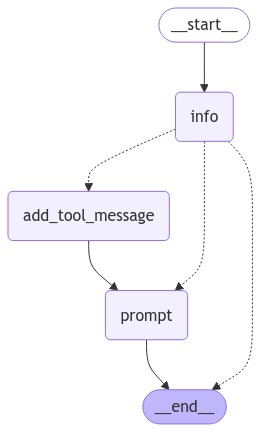

In [30]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
import uuid

config = {"configurable": {"thread_id": str(uuid.uuid4())}}
config

{'configurable': {'thread_id': '2295d16a-6426-4307-a434-bd4002c20d09'}}

In [32]:
user_input = "こんにちは！"
for event in graph.stream({"messages": [HumanMessage(content=user_input)]}, config=config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

こんにちは！
================================== Ai Message ==================================

こんにちは！どのようなお手伝いができますか？


In [33]:
user_input = "キャリアのアドバイスをするプロンプトを作りたい"
for event in graph.stream({"messages": [HumanMessage(content=user_input)]}, config=config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

キャリアのアドバイスをするプロンプトを作りたい
================================== Ai Message ==================================

了解しました！プロンプトテンプレートを作成するために、以下の情報を教えていただけますか？

1. プロンプトの目的
2. プロンプトテンプレートに渡される変数
3. 出力に関する禁止事項
4. 出力が必ず従うべき要件

これらの情報を教えていただければ、適切なプロンプトテンプレートを作成することができます。


In [34]:
user_input = "1. キャリアアドバイス, 2. 年齢、職種, 3. なし, 4. なし"
for event in graph.stream({"messages": [HumanMessage(content=user_input)]}, config=config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

1. キャリアアドバイス, 2. 年齢、職種, 3. なし, 4. なし
================================== Ai Message ==================================
Tool Calls:
  PromptInstructions (call_y0rqiGKIKL3gI7KAgzza0bsv)
 Call ID: call_y0rqiGKIKL3gI7KAgzza0bsv
  Args:
    objective: キャリアアドバイス
    variables: ['年齢', '職種']
    constraints: ['なし']
    requirements: ['なし']
================================= Tool Message =================================

PromptGenerated!
================================== Ai Message ==================================

---

### キャリアアドバイス

#### 年齢:
1. あなたの年齢を教えてください。

#### 職種:
2. 現在の職種や業種について教えてください。

---
